<a href="https://colab.research.google.com/github/margeumkim/BRIDGEMAIL/blob/master/BERT_Example_KSPL_EVAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Pre-Trained BERT


Install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.)

We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

If you're running this code on Google Colab, you will have to install this library each time you reconnect; the following cell will take care of that for you.

In [0]:
!pip install transformers

Now let's import pytorch, the pretrained BERT model, and a BERT tokenizer.

We'll explain the BERT model in detail in a later tutorial, but this is the pre-trained model released by Google that ran for many, many hours on Wikipedia and Book Corpus, a dataset containing +10,000 books of different genres. This model is responsible (with a little modification) for beating NLP benchmarks across a range of tasks. Google released a few variations of BERT models, but the one we'll use here is the smaller of the two available sizes ("base" and "large") and ignores casing, hence "uncased.""

**transformers** provides a number of classes for applying BERT to different tasks (token classification, text classification, ...). Here, we're using the basic **BertModel** which has no specific output task--it's a good choice for using BERT just to extract embeddings.

In [0]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicCOnfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Loading Enron emails data 
We'll load the Enron Emails dataset. For the purpose of exploratory data analysis, I will subset two accounts -- Kate Symes and Phillip Love. 


Let's import data from my Google drive 
** (but later, will need to combine with git - you must slice file so that each is <25MB) **

> NOTE: When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.
Once you have completed verification, go to the CSV file in Google Drive, right-click on it and select “Get shareable link”. The link will be copied into your clipboard. Paste this link into a string variable in Colab.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd

path = "/content/drive/My Drive/data/emails.csv"
emails_df = pd.read_csv(path)

# Dataset is now stored in a Pandas Dataframe

In [0]:
# Checking whether the file is loaded properly
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [0]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


Let's split the information in each message into different fields.

In [0]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [0]:
import email 

# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


Now, select Kate Symes and Phillip Love's account using the "user" column

In [0]:
user_list = ["symes-k", "love-p"]
email_address_list = [frozenset({'kate.symes@enron.com'}), frozenset({'phillip.love@enron.com'})]

#print (user_list[0])
#account_i_df = emails_df[emails_df["user"] == user_list[0]].reset_index()
account_j_df = emails_df[emails_df["user"] == user_list[1]].reset_index()
#ks_pl_emails_df = emails_df[emails_df["user"].isin(["symes-k", "love-p"])]
#account_i_df.head()

#print ("number of messages contained in " + str(user_list[0]) + "'s account:" + str(len(account_i_df)) )
print ("number of messages contained in " + str(user_list[1]) + "'s account:" + str(len(account_j_df)) )

#account_i_sent_df = account_i_df[account_i_df["From"] == email_address_list[0]].reset_index()
account_j_sent_df = account_j_df[account_j_df["From"] == email_address_list[1]].reset_index()

#print ("number of sent messages contained in " + str(user_list[0]) + "'s account:" + str(len(account_i_sent_df)) )
print ("number of sent messages contained in " + str(user_list[1]) + "'s account:" + str(len(account_j_sent_df)) )


number of messages contained in love-p's account:5002
number of sent messages contained in love-p's account:3100


In [0]:
del emails_df 

Select contents and for each person

In [0]:
#content_i_df = account_i_df["content"].reset_index()
#content_i_df.head()
#content_j_df = account_j_df["content"].reset_index()
#content_j_df.head()

Pre-process text content:


In [0]:
def email_clean(text):
    text = text.rstrip().lower()
    text = " ".join([i for i in text.split() if(not i.isdigit())])
    text = re.sub(r'\n--.*?\n', '', text, flags=re.DOTALL)
    text = re.sub(r'Forwarded by.*?Subject:', '', text, flags=re.DOTALL) 
    text = re.sub(r'Fwd:.*?Subject:', '', text, flags=re.DOTALL) 
    text = re.sub(r'Fw:.*?Subject:', '', text, flags=re.DOTALL)     
    text = re.sub(r'FW:.*?Subject:', '', text, flags=re.DOTALL)         
    text = re.sub(r'Forwarded:.*?Subject:', '', text, flags=re.DOTALL)         
    text = re.sub(r'From:.*?Subject:', '', text, flags=re.DOTALL)
    text = re.sub(r'PM', '', text, flags=re.DOTALL)
    text = re.sub(r'AM', '', text, flags=re.DOTALL)
    text = re.sub(r'enron america corp', '', text, flags=re.DOTALL)
    text = re.sub(r'enron', '', text, flags=re.DOTALL)    
    text = re.sub(r'etc', '', text, flags=re.DOTALL)    
    text = re.sub(r'\n', '', text, flags=re.DOTALL)    
    text = re.sub(r'.*?@.*?', '', text, flags=re.DOTALL)
    text = re.sub(r'http://.*?', '', text, flags=re.DOTALL)    
    text = re.sub(r'cc?', '', text, flags=re.DOTALL)    
    text = re.sub(r'subject', '', text, flags=re.DOTALL)    
    text = re.sub(r'from', '', text, flags=re.DOTALL)    
    text = re.sub(r'sent', '', text, flags=re.DOTALL)        
    text = re.sub(r'to', '', text, flags=re.DOTALL)            
#    text = re.sub(signoff_1, '', text, flags=re.DOTALL)    
#    text = re.sub(signoff_2, '', text, flags=re.DOTALL)       
    text = re.sub(signoff_3, '', text, flags=re.DOTALL)   
    return text


def clean(text):
#    stop = set(stopwords.words('english'))
#    stop.update(("to","cc","subject","http","from","sent",
#                 "aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa", 
#                 "enron america corp", "enron", "etc", "na", signoff_1, signoff_2, signoff_3))
    exclude = set(string.punctuation) - {'.'}
    lemma = WordNetLemmatizer()
    porter= PorterStemmer()
    
#    text = text.rstrip().lower()
    digit_free = " ".join([i for i in text.lower().split() if(not i.isdigit())])
    punc_free = ''.join(ch for ch in digit_free if ch not in exclude)
#    normalized = " ".join(lemma.lemmatize(word) for word in punc_free)
    #stem = " ".join(porter.stem(token) for token in normalized.split())
    
    return punc_free


In [0]:
#import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')

import re
#from nltk.corpus import stopwords 
#from nltk.stem.wordnet import WordNetLemmatizer
#import string
#from nltk.stem.porter import PorterStemmer 


#signoff_1 = str(account_i_df["user"][0].split('-')[1] + list(account_i_df["user"][0].split('-')[0])[0])
#print(signoff_1)
#signoff_2 = str(list(signoff_1)[0])
#print(signoff_2)
#signoff_3 = str(account_i_sent_df["user"][0].split('-')[0])
#print(signoff_3)

#account_i_clean_content =[]
#for text in account_i_sent_df['content']:
#    email_dot_split = email_clean(text).split('.')
#    for item in email_dot_split:
#        account_i_clean_content.append(item.split('>'))
#    account_i_clean_content.append(clean(email_clean(text)))

#signoff_1 = str(account_j_df["user"][0].split('-')[1] + list(account_j_df["user"][0].split('-')[0])[0])
#print(signoff_1)
#signoff_2 = str(list(signoff_1)[0])
#print(signoff_2)
signoff_3 = str(account_j_sent_df["user"][0].split('-')[0])
print(signoff_3)

account_j_clean_content = []
for text in account_j_sent_df['content']:
    email_dot_split = email_clean(text).split('.')
    for item in email_dot_split:
        account_j_clean_content.append(item.split('>'))
#    account_j_clean_content.append(clean(email_clean(text)))

## Flattening nested lists
#account_i_content = [] 
#for text in account_i_clean_content:
#    for item in text:
#      if len(list(item.split())) >3: 
#        if len(list(item.split())) < 101: 
#          account_i_content.append(item)

account_j_content = [] 
for text in account_j_clean_content:
    for item in text:
      if len(list(item.split())) >3: 
        if len(list(item.split())) < 101: 
          account_j_content.append(item)      

love


In [0]:
# Create labels 
#account_i_content = pd.DataFrame(account_i_content)
#account_i_content.loc[account_i_content.label==0]
#df.loc[df.label == 0].sample(5)[['sentence', 'label']]

In [0]:
print(account_j_content[-20])
len(list(account_j_content[-20].split()))

per bass- like last year we get guys, one must remain on ir for the entire week


17

Let's randomly sample x many sentences from this account

In [0]:
#print(len(account_j_content))
#print (account_j_content[-2])

#print ("number of sentences in " + str(user_list[0]) + "'s account:" + str(len(account_i_content)) )
print ("number of sentences in " + str(user_list[1]) + "'s account:" + str(len(account_j_content)) )

# Let's randomly sample 300 sentences 
import random 

#type(account_i_content)
#account_i_300 = random.sample(account_i_content, 300)
account_j_300 = random.sample(account_j_content, 300)

#print (len(account_i_300))
#print (len(account_j_300))

number of sentences in love-p's account:13704


# 3. Tokenization & Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

1. A **special token**, [SEP], to mark the end of a sentence, or the separation between two sentences
2. A **special token**, [CLS], at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is.
3. Tokens that conform with the fixed vocabulary used in BERT
4. The **Token IDs** for the tokens, from BERT's tokenizer
5. **Mask IDs** to indicate which elements in the sequence are tokens and which are padding elements
6. **Segment IDs** used to distinguish different sentences
7. **Positional Embeddings** used to show token position within the sequence
Luckily, the transformers interface takes care of all of the above requirements (using the tokenizer.encode_plus function).

Since this is intended as an introduction to working with BERT, though, we're going to perform these steps in a (mostly) manual way.

For an example of using tokenizer.encode_plus, see the next post on Sentence Classification [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/).

##3.1. BERT Tokenizer
To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [0]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Le'ts apply the tokenizer to one sentence just to see the output

In [0]:
# Print the original sentence.
print(' Original: ', account_j_300[1])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(account_j_300[1]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(account_j_300[1])))

 Original:   in auburn,? please forward this  them for wider distribution among the various auburn? lubs in the usa
Tokenized:  ['in', 'auburn', ',', '?', 'please', 'forward', 'this', 'them', 'for', 'wider', 'distribution', 'among', 'the', 'various', 'auburn', '?', 'lu', '##bs', 'in', 'the', 'usa']
Token IDs:  [1999, 12704, 1010, 1029, 3531, 2830, 2023, 2068, 2005, 7289, 4353, 2426, 1996, 2536, 12704, 1029, 11320, 5910, 1999, 1996, 3915]


Let's 

When we actually convert all of our sentences, we'll use the tokenize.encode function to handle both steps, rather than calling tokenize and convert_tokens_to_ids separately.

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.

We are required to:

1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

#### Special tokens
* [SEP] at the end of every sentence
* [CLS] for classification tasks -- the beginning of every sentence.

#### Sentence Length & Attention Mask
The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special [PAD] token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. For example, with a Tesla K80:

MAX_LEN = 128 --> Training epochs take ~5:28 each

MAX_LEN = 64 --> Training epochs take ~2:57 each

## 3.3 Tokenize Dataset
The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [0]:
max_len = 0

# For every sentence...
for sent in account_j_300:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  154


As there are some longer test sentences, I'll set the maximum length to 500.

Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.

The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in account_j_300:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
token_tensor = torch.cat(input_ids, dim=0)
attention_masks_tensor = torch.cat(attention_masks, dim=0)
#labels = torch.tensor(labels)  # currently, not using labels (won't evaluate it... using just pre-trained model)

# Print sentence 0, now as a list of IDs.
print('Original: ', account_j_content[2])
print('Token IDs:', token_tensor[2])

# started running 12:08

Original:   i am off work the next day, so i will try and make it
Token IDs: tensor([  101,  4561,  1024,  2019,  2017,  2507,  2033,  1996,  4751,  2006,
         1996,  6970,  6155,  2243, 16405, 25032, 11022, 13075,  2937,  2063,
         1002,  4090,  2575,  2243, 21554, 25604,  2692,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [0]:
print (len(attention_masks_tensor)) #73725 sentences for Kate Symes  #42121 sentences for Phillip Love
# after subsetting into sent mails, 18865 sentences for Phillip Love
print (len(token_tensor[2]))

300
100


In [0]:
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [0]:
segment_ids = get_segments(token_tensor, 500) 

IndexError: ignored

## 3.4. Tokenizing in JSON file to extract attentions (link [here](https://github.com/clarkkev/attention-analysis/blob/master/preprocess_unlabeled.py))

Don't think I will use this method. 
Just use the plain way--and use the config.attention... function to extract attention matrices and summarize!! 


# 4. Extracting Embeddings

## 4.1. Running BERT on our text
Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.

Calling from_pretrained will fetch the model from the internet. When we load the bert-base-uncased, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [0]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Next, let's evaluate BERT on our text in each account, and fetch the hidden states of the network!

> Side note: torch.no_grad tells PyTorch not to construct the compute graph during this forward pass (since we won't be running backprop here)--this just reduces memory consumption and speeds things up a little.

In [0]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model.config(token_tensor)   # currently, ignoring the segment tensor

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

## 3.2. Understanding the Output

The full set of hidden states for this model, stored in the object hidden_states, is a little dizzying. This object has four dimensions, in the following order:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn't BERT only have 12? It's 13 because the first element is the input embeddings, the rest is the outputs of each of BERT's 12 layers.

That’s 219,648 unique values just to represent our one sentence!

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [0]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 300
Number of tokens: 100
Number of hidden units: 768


Let's take a quick look at the range of values for a given layer and token.

You'll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

In [0]:
input_ids[0:10]

[tensor([[ 101, 2003, 2023, 1996, 1041, 4747, 1001, 1010, 1041, 4747, 2193, 2024,
          2682, 2157, 2085,  102,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0]]),
 tensor([[  101,  1999, 12704,  1010,  1029,  3531,  2830,  2023,  2068,  2005,
           7289,  4353,  2426,  1996,  2536, 12704,  1029, 11320,  5910,  1999,
           1996,  3915,   102,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,  

In [48]:
hidden_states[12]

tensor([[[-0.4753,  0.2776,  0.5053,  ..., -0.4784,  0.3709, -0.6874],
         [-0.3332, -0.0111,  0.3280,  ...,  0.2746,  0.8266,  0.9511],
         [-0.8477,  0.1560,  0.4526,  ..., -0.2154,  0.7049,  0.3528],
         ...,
         [ 0.2272, -0.3457,  0.9711,  ..., -0.7166,  0.1013, -1.0462],
         [ 0.2790, -0.3883,  0.9401,  ..., -0.6547,  0.0555, -1.0185],
         [ 0.0465, -0.0130,  0.6212,  ..., -0.5745, -0.1770, -0.9787]],

        [[-0.5065,  0.2390,  0.4681,  ..., -0.5025,  0.4144, -0.9086],
         [-0.8391, -0.1461, -0.5687,  ..., -0.1536,  1.0357, -0.0970],
         [ 0.1582, -0.3228, -0.3145,  ..., -0.3783,  0.4501, -0.7087],
         ...,
         [ 0.2935, -0.2912,  0.9758,  ..., -0.6900,  0.1579, -1.1250],
         [ 0.2018, -0.3479,  0.9975,  ..., -0.6658,  0.0553, -1.0751],
         [ 0.2674, -0.0999,  0.8320,  ..., -0.6640,  0.0024, -1.2761]],

        [[-0.4203,  0.2426,  0.4283,  ..., -0.3356,  0.5490, -0.4771],
         [-0.4498,  1.1875, -0.2444,  ..., -0

In [50]:
tokenizer.vocab.get("please")  # 1996
outputs.attention_weights

AttributeError: ignored

tensor([  101,  1999, 12704,  1010,  1029,  3531,  2830,  2023,  2068,  2005,
         7289,  4353,  2426,  1996,  2536, 12704,  1029, 11320,  5910,  1999,
         1996,  3915,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
 in auburn,? please forward this  them for wider distribution among the various auburn? lubs in the usa


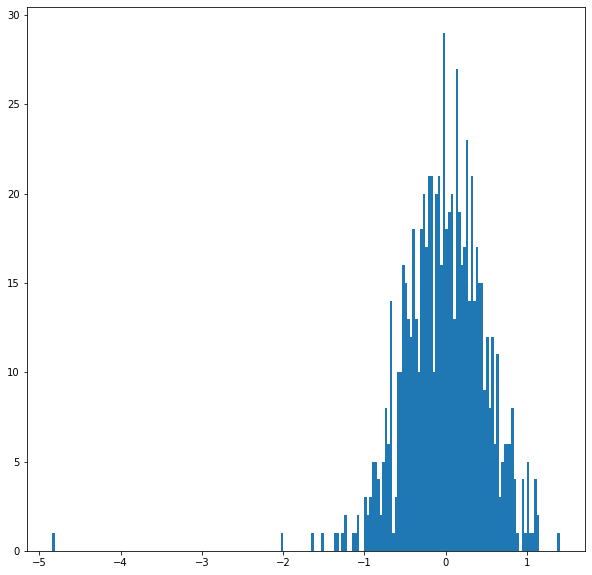

In [46]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 1    # 6 and 10 are bank
#sentence_i = 10
layer_i = 12
vec = hidden_states[layer_i][batch_i][token_i]

print (token_tensor[token_i]) 
print (account_j_300[token_i]) 

#indexed_tokens = tokenizer.convert_tokens_to_ids(token_tensor)

# Display the words with their indeces.
#for tup in zip(account_j_300, indexed_tokens):
#    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token.

Current dimensions:

[# layers, # batches, # tokens, # features]

Desired dimensions:

[# tokens, # layers, # features]

Luckily, PyTorch includes the permute function for easily rearranging the dimensions of a tensor.

However, the first dimension is currently a Python list!

In [0]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


Let's combine the layers to make this one whole big tensor.

In [0]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

Let's get rid of the "batches" dimension since we don't need it.

In [0]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

Finally, we can switch around the "layers" and "tokens" dimensions with permute.

In [0]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

##3.3. Creating word and sentence vectors from hidden states

### Word Vectors

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors...but which layer or combination of layers provides the best representation?

Unfortunately, there's no single easy answer... Let's try a couple reasonable approaches, though. Afterwards, I'll point you to some helpful resources which look into this question further.

Word Vectors
To give you some examples, let's create word vectors two ways.

First, let's **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length 4 x 768 = 3,072.

In [0]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072


As an alternative method, let's try creating the word vectors by **summing** together the last four layers.

In [0]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768


### Sentence Vectors


To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [0]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

In [0]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


##3.4. Confirming contextually dependent vectors

To confirm that the value of these vectors are in fact contextually dependent, let's look at the different instances of the word "bank" in our example sentence:

"After stealing money from the **bank vault**, the **bank robber** was seen fishing on the **Mississippi river bank**."

Let's find the index of those three instances of the word "bank" in the example sentence.

In [0]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 after
2 stealing
3 money
4 from
5 the
6 bank
7 vault
8 ,
9 the
10 bank
11 robber
12 was
13 seen
14 fishing
15 on
16 the
17 mississippi
18 river
19 bank
20 .
21 [SEP]


They are at 6, 10, and 19.

For this analysis, we'll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [0]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

First 5 vector values for each instance of "bank".

bank vault    tensor([ 3.3596, -2.9805, -1.5421,  0.7065,  2.0031])
bank robber   tensor([ 2.7359, -2.5577, -1.3094,  0.6797,  1.6633])
river bank    tensor([ 1.5266, -0.8895, -0.5152, -0.9298,  2.8334])


We can see that the values differ, but let's calculate the cosine similarity between the vectors to make a more precise comparison.



In [0]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

Vector similarity for  *similar*  meanings:  0.94
Vector similarity for *different* meanings:  0.69
